# DDoS Attack Prediction

## Set up

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/STEDWARDS/MATH-3439-01/Project 3/50k_50k.csv')
complete_df = pd.read_csv('/content/drive/MyDrive/STEDWARDS/MATH-3439-01/Project 3/final_dataset.csv')

## Data Prep

In [ ]:
# , 'Fwd Seg Size Min', 'Init Bwd Win Byts'
cols_to_exclude = ['Unnamed: 0', 'Flow ID', 'Src IP', 'Dst IP', 'Timestamp']
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.difference(cols_to_exclude)
new_df = df.dropna()

In [ ]:
for col in new_df.select_dtypes(include=[np.number]).columns:
    threshold = np.percentile(new_df[col].dropna(), 99)
    new_df.loc[new_df[col] > threshold, col] = threshold

<ipython-input-5-eda9334baf8c>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7745257.55' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_df.loc[new_df[col] > threshold, col] = threshold
<ipython-input-5-eda9334baf8c>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '63439.41' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_df.loc[new_df[col] > threshold, col] = threshold
<ipython-input-5-eda9334baf8c>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '117595298.29' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_df.loc[new_df[col] > threshold, col] = threshold
<ipython-input-5-eda9334baf8c>:3: FutureWarning: 

In [ ]:
X = new_df[numeric_columns]
y = new_df['Label']

# If necessary, encode the target
# For example, if y contains strings like 'ddos' and 'benign':
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

## Gradient Boosting Classifier

In [ ]:
#### TRAIN THE MODEL GRADIENT BOOSTER CLASSIFIER
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [ ]:
# Make predictions on the test set
y_pred = gbc.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9952
           1       1.00      1.00      1.00     10000

    accuracy                           1.00     19952
   macro avg       1.00      1.00      1.00     19952
weighted avg       1.00      1.00      1.00     19952

Accuracy: 0.9979951884522855
Confusion Matrix:
 [[9924   28]
 [  12 9988]]


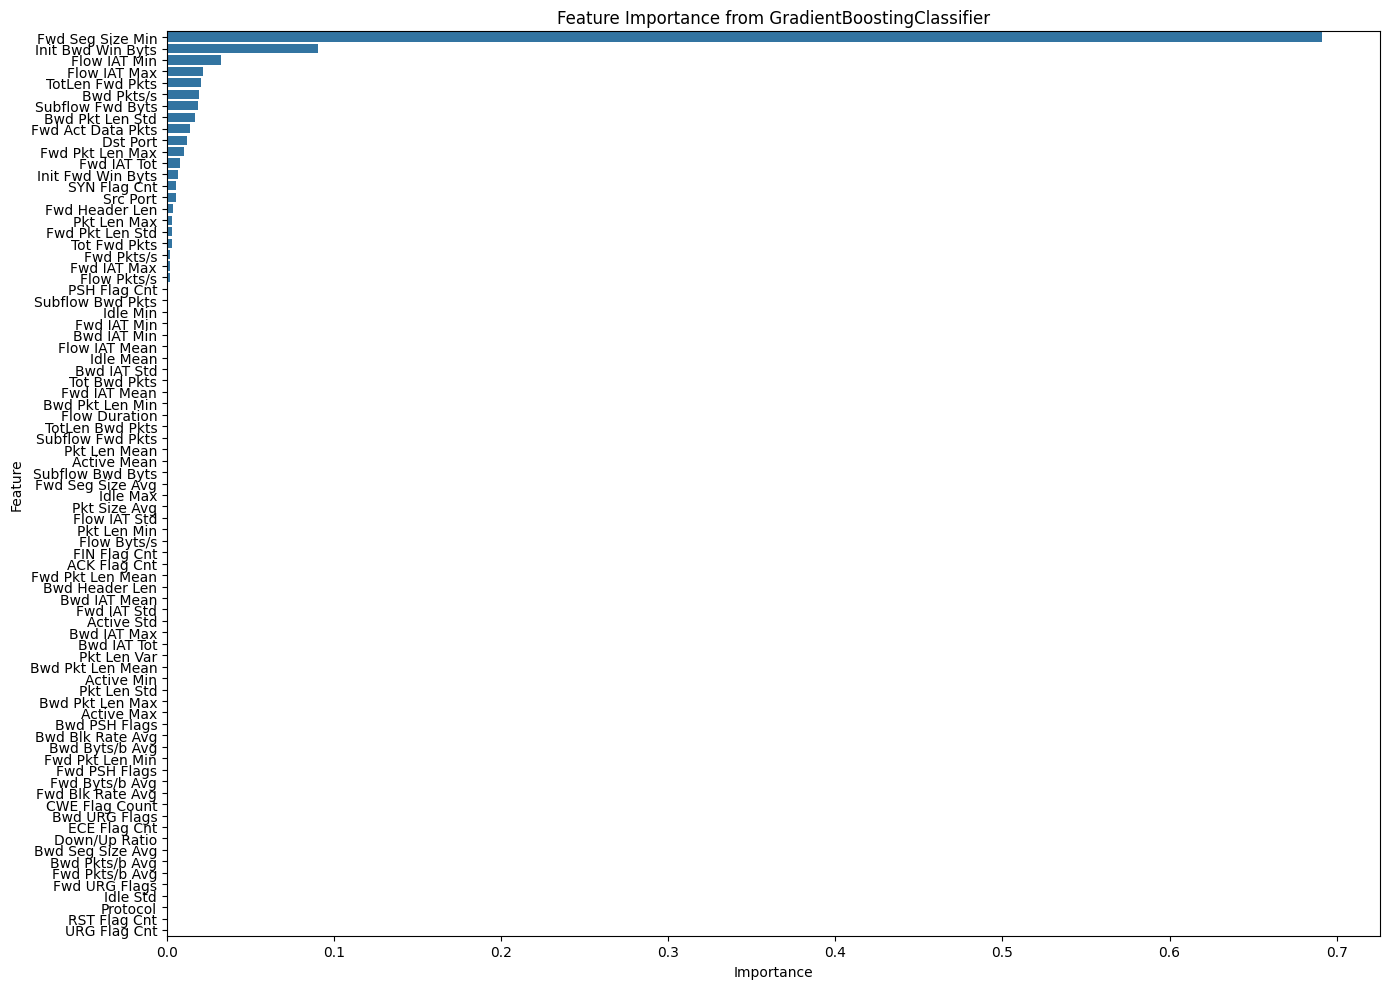

In [ ]:
#### COEFFICIENT SCORES
# Get feature importances from the model
importances = gbc.feature_importances_
features = X_train.columns

# Create a DataFrame for easy viewing and sorting
feat_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title("Feature Importance from GradientBoostingClassifier")
plt.tight_layout()
plt.show()

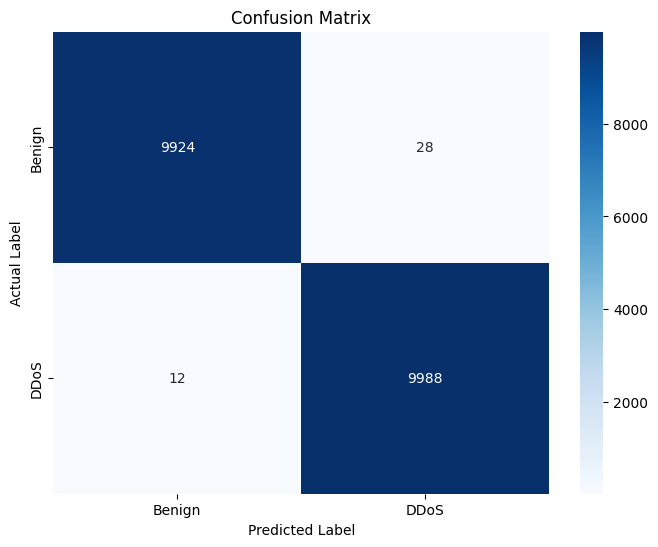

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a custom list of labels
# Assuming le.classes_ returns ['Benign', 'ddos']
custom_labels = ['Benign', 'DDoS']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=custom_labels, yticklabels=custom_labels)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

## Logistic Regression

In [ ]:
#### TRAIN THE MODEL LOGISTICAL REGRESSION
# Train Logistic Regression with L1 penalty (LASSO)
lasso_clf = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
lasso_clf.fit(X_train, y_train)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

In [ ]:
# Retrieve features with non-zero coefficients
selected_features = X_train.columns[lasso_clf.coef_.ravel() != 0]
print("Selected features with non-zero coefficients:")
print(selected_features)

# Evaluate model performance
y_pred = lasso_clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Selected features with non-zero coefficients:
Index(['ACK Flag Cnt', 'Active Max', 'Active Mean', 'Active Min', 'Active Std',
       'Bwd Header Len', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Min',
       'Bwd IAT Std', 'Bwd IAT Tot', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Bwd Pkts/s', 'Bwd Seg Size Avg',
       'CWE Flag Count', 'Down/Up Ratio', 'Dst Port', 'ECE Flag Cnt',
       'FIN Flag Cnt', 'Flow Byts/s', 'Flow Duration', 'Flow IAT Max',
       'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Pkts/s',
       'Fwd Act Data Pkts', 'Fwd Header Len', 'Fwd IAT Max', 'Fwd IAT Mean',
       'Fwd IAT Min', 'Fwd IAT Std', 'Fwd IAT Tot', 'Fwd PSH Flags',
       'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Std', 'Fwd Pkts/s', 'Fwd Seg Size Avg', 'Fwd Seg Size Min',
       'Idle Max', 'Idle Mean', 'Idle Min', 'Idle Std', 'Init Bwd Win Byts',
       'Init Fwd Win Byts', 'PSH Flag Cnt', 'Pkt Len Max', 'Pkt Len 

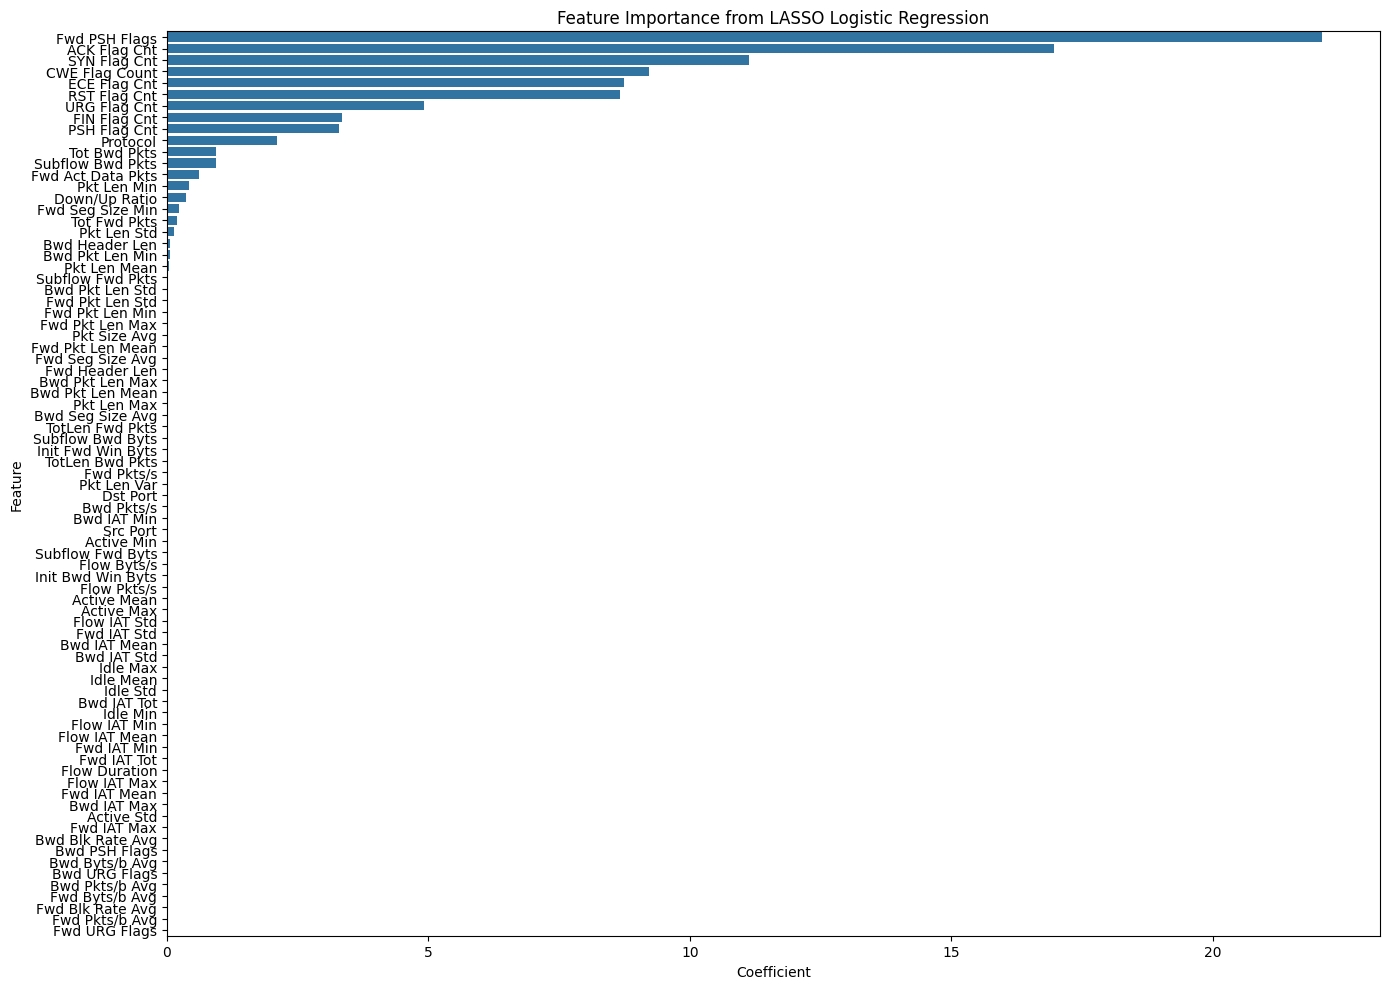

In [ ]:
# Get coefficients (absolute values for ranking)
lasso_coeff = np.abs(lasso_clf.coef_.ravel())
features = X_train.columns

# Create a DataFrame for easy viewing and sorting
lasso_imp_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': lasso_coeff
}).sort_values(by='Coefficient', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(14, 10))
sns.barplot(x='Coefficient', y='Feature', data=lasso_imp_df)
plt.title("Feature Importance from LASSO Logistic Regression")
plt.tight_layout()
plt.show()

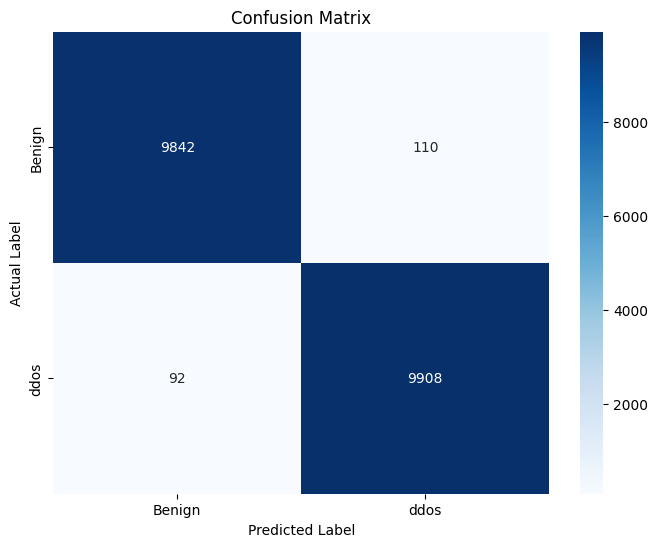

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

## Decision Tree

In [ ]:
# --- Decision Tree ---
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)

In [ ]:
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Decision Tree Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9952
           1       1.00      1.00      1.00     10000

    accuracy                           1.00     19952
   macro avg       1.00      1.00      1.00     19952
weighted avg       1.00      1.00      1.00     19952

Decision Tree Accuracy: 0.9992983159582999
Decision Tree Confusion Matrix:
[[9942   10]
 [   4 9996]]


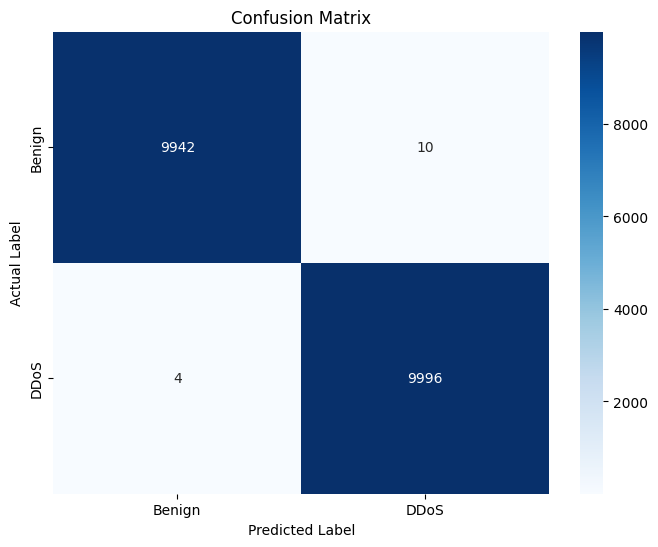

In [ ]:
cm = confusion_matrix(y_test, y_pred_dt)
custom_labels = ['Benign', 'DDoS']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=custom_labels, yticklabels=custom_labels)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

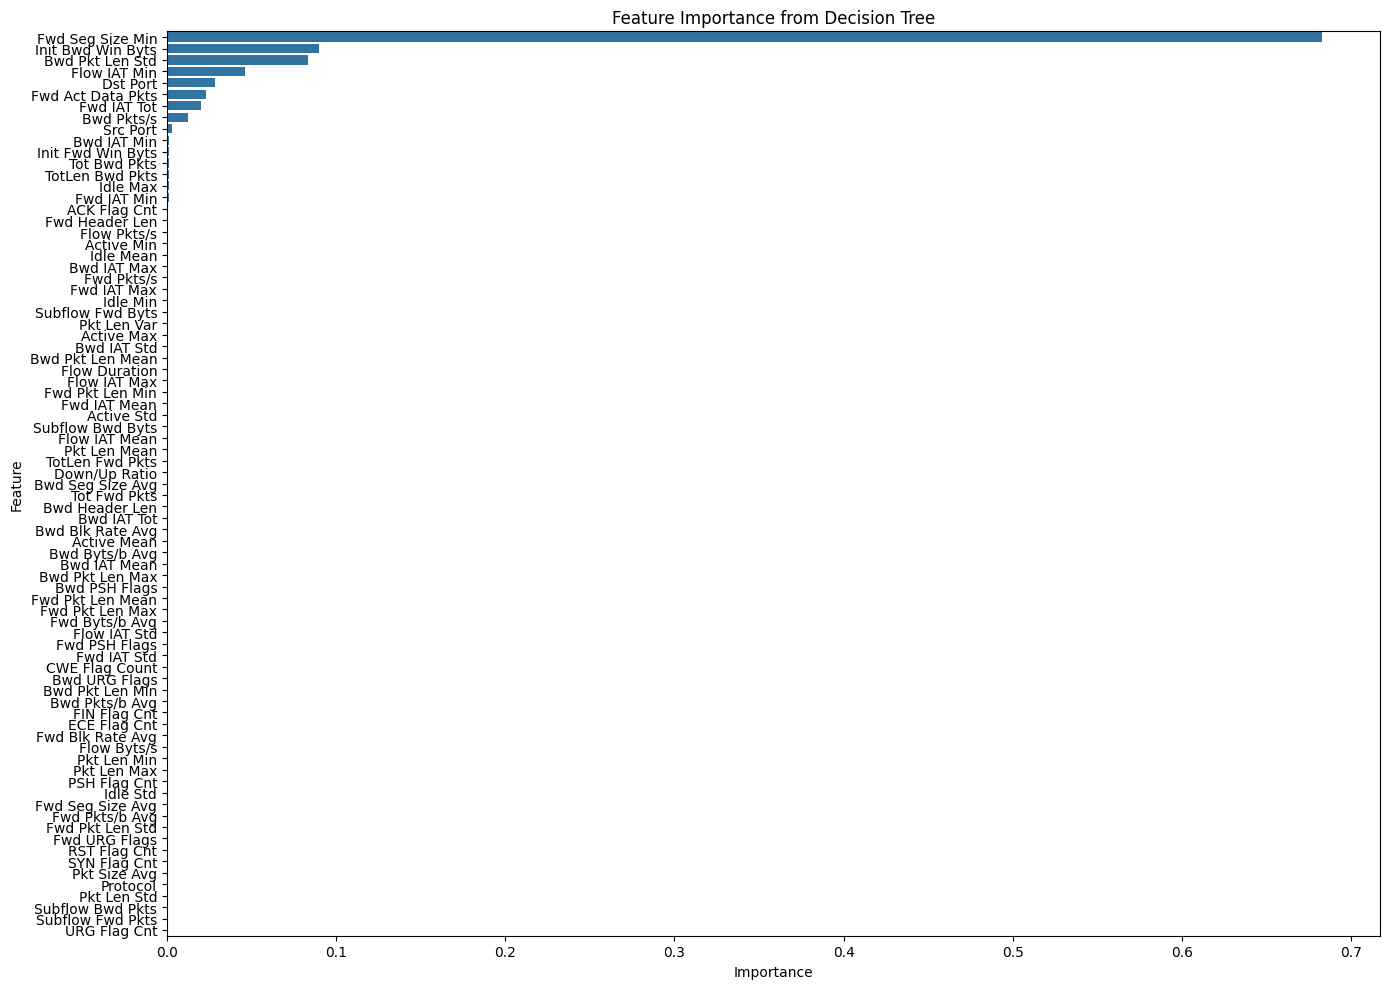

In [ ]:
# Get feature importances from the Decision Tree model
dt_importances = dt_clf.feature_importances_
features = X_train.columns

# Create a DataFrame for easy viewing and sorting
dt_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': dt_importances
}).sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', data=dt_imp_df)
plt.title("Feature Importance from Decision Tree")
plt.tight_layout()
plt.show()

## K-Nearest Neighbor

In [ ]:
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)
y_pred_knn = knn_clf.predict(X_test)

In [ ]:
print("\nk-Nearest Neighbors Classification Report:")
print(classification_report(y_test, y_pred_knn))
print("k-NN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("k-NN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))


k-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9952
           1       0.99      0.99      0.99     10000

    accuracy                           0.99     19952
   macro avg       0.99      0.99      0.99     19952
weighted avg       0.99      0.99      0.99     19952

k-NN Accuracy: 0.9917301523656776
k-NN Confusion Matrix:
[[9846  106]
 [  59 9941]]


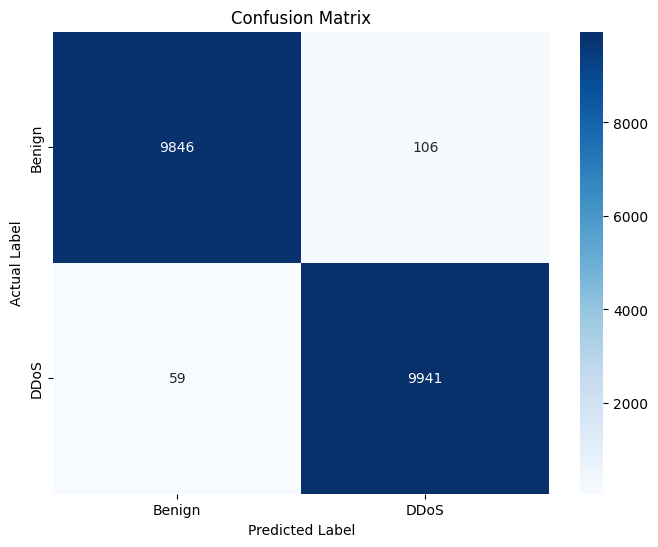

In [ ]:
cm = confusion_matrix(y_test, y_pred_knn)
custom_labels = ['Benign', 'DDoS']
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=custom_labels, yticklabels=custom_labels)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()